# cy3sbml
Mapping simulation & analysis data on SBML networks.  
In this example we use the species concentration from a timecourse simulation to map them to the node size.

In [13]:
# !!! Start Cytoscape 3 with cyREST App

In [8]:
from __future__ import print_function, division
import pandas as pd
from matplotlib import pylab as plt
import roadrunner
%matplotlib inline

## Load model
Loading Elowitz2000 - Repressilator in tellurium & roadrunner. A synthetic oscillatory network of transcriptional regulators.  
The model is available from Biomodels as BIOMD0000000012.

In [58]:
import roadrunner
biomodel = "BIOMD0000000012"
r = roadrunner.RoadRunner("{}.xml".format(biomodel))
model = r.getModel()

## Simulate model
Simple timecourse simulation which we want to visualize with cy3sbml.

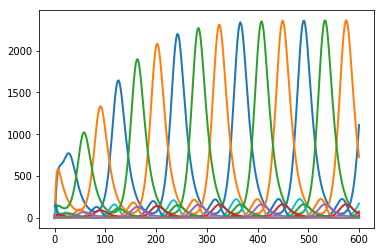

['time', 'PX', 'PY', 'PZ', 'X', 'Y', 'Z', 'Reaction1', 'Reaction2', 'Reaction3', 'Reaction4', 'Reaction5', 'Reaction6', 'Reaction7', 'Reaction8', 'Reaction9', 'Reaction10', 'Reaction11', 'Reaction12']


In [59]:
r.reset()

model.getReactionIds()
model.getFloatingSpeciesIds()

r.timeCourseSelections = ['time'] + model.getFloatingSpeciesIds() + model.getReactionIds()
data = r.simulate(start=0, end=600, steps=300)
r.plot();
print(r.timeCourseSelections)

## Convert to dataframe
We store the resulting data in a `pandas` dataframe. `roadrunner` returns a NamedArray, we import this into pandas.

In [60]:
# sbml ids from timeCourseSelections
sbml_ids = [name.replace("[", "").replace("]", "") 
            for name in r.timeCourseSelections]

print(sbml_ids)

# create dataframe
df = pd.DataFrame(data[:, 1:], index=data[:,0], columns=sbml_ids[1:])
df.head(10)

['time', 'PX', 'PY', 'PZ', 'X', 'Y', 'Z', 'Reaction1', 'Reaction2', 'Reaction3', 'Reaction4', 'Reaction5', 'Reaction6', 'Reaction7', 'Reaction8', 'Reaction9', 'Reaction10', 'Reaction11', 'Reaction12']


,PX,PY,PZ,X,Y,Z,Reaction1,Reaction2,Reaction3,Reaction4,Reaction5,Reaction6,Reaction7,Reaction8,Reaction9,Reaction10,Reaction11,Reaction12
0.0,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.931472,0.000000,0.000000,138.629436,0.000000,0.000000,0.000000,0.000000,30.000000,30.000000,30.000000
2.0,218.538704,358.026782,84.588884,21.233519,23.608864,5.866252,7.358977,8.182209,2.033088,147.179535,163.644178,40.661761,15.147949,24.816525,5.863255,5.506924,1.001491,0.399478
4.0,428.938247,536.662776,131.034639,15.559774,12.482022,3.295798,5.392607,4.325939,1.142237,107.852138,86.518783,22.844734,29.731734,37.198629,9.082629,2.584705,0.288379,0.195576
6.0,542.465621,585.396059,146.531395,11.033627,6.564237,1.902649,3.823964,2.274991,0.659408,76.479273,45.499826,13.188161,37.600852,40.576563,10.156782,2.108413,0.192072,0.169279
8.0,596.569596,572.333053,146.992677,8.518859,3.533290,1.198351,2.952412,1.224545,0.415317,59.048232,24.490899,8.306337,41.351053,39.671104,10.188756,2.096287,0.164133,0.175678
10.0,621.043069,532.672172,141.004085,7.402872,1.994072,0.869004,2.565640,0.691093,0.301174,51.312801,13.821851,6.023478,43.047425,36.922021,9.773658,2.262179,0.153813,0.198052
12.0,634.159346,483.803127,133.027345,7.161642,1.214618,0.747167,2.482036,0.420955,0.258948,49.640722,8.419092,5.178965,43.956576,33.534677,9.220753,2.515039,0.148764,0.233475
14.0,646.192780,433.991078,125.380804,7.436776,0.818490,0.748080,2.577390,0.283667,0.259265,51.547804,5.673340,5.185292,44.790670,30.081969,8.690735,2.798536,0.144399,0.282448
16.0,662.189607,386.907860,119.309186,7.970971,0.613361,0.831366,2.762528,0.212575,0.288129,55.250561,4.251495,5.762590,45.899486,26.818409,8.269883,3.058289,0.138958,0.346938
18.0,683.569249,343.956441,115.546919,8.554609,0.501896,0.980501,2.964802,0.173944,0.339816,59.296034,3.478881,6.796315,47.381410,23.841244,8.009102,3.237258,0.132272,0.429913


# Connect to Cytoscape
We use py2cytoscape has wrapper modules for cyREST RESTful API. Hereby we can can access Cytoscape features in more Pythonic way instead of calling raw REST API via HTTP.

In [61]:
# start client
import json
import py2cytoscape
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.style import StyleUtil

cy = CyRestClient()

## Load SBML in cy3sbml
All the interaction with cytoscape from now on is via simple REST API!
`py2cytoscape` is only a simple wrapper to hide some of the REST calls.

The same can be done from anywhere (different programming language, ...).

In [62]:
# Reset
cy.session.delete()

In [63]:
# Step 2: Load SBML network
networks = cy.network.create_from('BIOMD0000000012.xml')
print(networks)

[<py2cytoscape.data.cynetwork.CyNetwork object at 0x7fc030e30470>, <py2cytoscape.data.cynetwork.CyNetwork object at 0x7fc030e300f0>, <py2cytoscape.data.cynetwork.CyNetwork object at 0x7fc030e30cf8>]


### Information about SBML networks

In [64]:
# Get information about SBML networks
base_net = None
for net in networks:
    # unique id of cytoscape objects
    net_suid = net.get_id()
    net_name = net.get_network_value(column='name')
    print(net.get_network_value(column='name'))
    if (net_name.startswith(b'Base')):
        base_net = net

# Selected the Base network (reaction - species graph of sbml file)
print('-'*60)
print (base_net)
print('-'*60)

b'All: Elowitz2000 - Repressilator'
b'Base: Elowitz2000 - Repressilator'
b'Kinetic: Elowitz2000 - Repressilator'
------------------------------------------------------------
------------------------------------------------------------


In [81]:
## Select network view
# TODO:

### Information about nodes

In [65]:
# get node and edges
nodes = base_net.get_nodes()
edges = base_net.get_edges()

print('* This network has ' + str(len(nodes)) + ' nodes and ' + str(len(edges)) + ' edges\n') 

# Get a row in the node table as pandas Series object
node0 = nodes[0]
row = base_net.get_node_value(id=node0)
print(row)

# Or, pick one cell in the table
cell = base_net.get_node_value(id=node0, column='name')
print('\nThis node has name: ' + str(cell))

* This network has 18 nodes and 18 edges

SUID                             686
chebi                    CHEBI:33699
compartmentCode                    1
cyId                         _905781
derivedUnits               substance
hasOnlySubstanceUnits           True
kegg.compound                 C00046
label                      TetR mRNA
metaId                       _905781
name                       TetR mRNA
sbml compartment                cell
sbml id                            Y
sbml initial amount               20
sbml type                    species
sbml type ext                species
sbo                      SBO:0000250
selected                       False
shared name                TetR mRNA
uniprot                       P04483
value                             20
dtype: object

This node has name: b'TetR mRNA'


### Node table
All table attributes are available and can be manipulated.

In [66]:
# cell = base_net.get_node_value(id=node0, column='name')
node_table = base_net.get_node_table()
node_table.head()

,shared name,cyId,sbml type,label,metaId,unitSid,kind,scale,multiplier,sbo,...,chebi,kegg.compound,reversible,math,kineticLaw,variable,compartmentCode,sbml type ext,name,selected
SUID,,,,,,,,,,,,,,,,,,,,,
688,cI mRNA,_905802,species,cI mRNA,_905802,NaN,NaN,NaN,NaN,SBO:0000250,...,CHEBI:33699,C00046,NaN,NaN,NaN,NaN,1.0,species,cI mRNA,False
722,translation of CI,_905923,reaction,translation of CI,_905923,NaN,NaN,NaN,NaN,SBO:0000184,...,NaN,NaN,False,NaN,k_tl*Z,NaN,NaN,reaction irreversible,translation of CI,False
690,degradation of LacI transcripts,_905823,reaction,degradation of LacI transcripts,_905823,NaN,NaN,NaN,NaN,SBO:0000179,...,NaN,NaN,False,NaN,kd_mRNA*X,NaN,NaN,reaction irreversible,degradation of LacI transcripts,False
757,transcription of TetR,_906022,reaction,transcription of TetR,_906022,NaN,NaN,NaN,NaN,SBO:0000183,...,NaN,NaN,False,NaN,a0_tr+a_tr*KM^n/(KM^n+PX^n),NaN,NaN,reaction irreversible,transcription of TetR,False
696,degradation of TetR transcripts,_905842,reaction,degradation of TetR transcripts,_905842,NaN,NaN,NaN,NaN,SBO:0000179,...,NaN,NaN,False,NaN,kd_mRNA*Y,NaN,NaN,reaction irreversible,degradation of TetR transcripts,False


### Find nodes for sbml ids
We now find the nodes which correspond to the species we simulated in the model.
The suid (unique node identifiers) are retrieved and stored for lookup.

In [67]:
node_suids = []

# logical indexing to find the nodes
for sid in sbml_ids[1:]:
    suid_index = node_table[node_table["sbml id"]==sid].index
    node_suids.append(suid_index.get_values()[0])

suid2sid = dict(zip(node_suids, sbml_ids[1:]))
suid2sid

{678: 'PX',
 680: 'PY',
 682: 'PZ',
 684: 'X',
 686: 'Y',
 688: 'Z',
 690: 'Reaction1',
 696: 'Reaction2',
 702: 'Reaction3',
 708: 'Reaction4',
 715: 'Reaction5',
 722: 'Reaction6',
 729: 'Reaction7',
 735: 'Reaction8',
 741: 'Reaction9',
 747: 'Reaction10',
 757: 'Reaction11',
 767: 'Reaction12'}

### Get CyNetworkView

CyNetworkView is a reference to a network view in your current Cytoscape session. This means CyNetworkView objects do not include actual data, such as node size or edge stroke colors. Instead, they hold a location of the data and create actual REST calls when you execute get/update methods for nodes and edges. 

In [79]:
# Get views for a network: Cytoscape "may" have multiple views, and that's why it returns list instead of an object.
view_ids = base_net.get_views() 
print(view_ids)

# format option specify the return type
view1 = base_net.get_view(view_ids[0], format='view')

# This is a CyNetworkView object, not dictionary
print(view1)

[996]


In [80]:
from py2cytoscape.data.util_network import NetworkUtil as util
import time

# DataFrame for node views
df_vs_node = pd.DataFrame(index=node_suids, 
                  columns=['NODE_WIDTH', 'NODE_HEIGHT'])

for timepoint in df.index:
    # print(timepoint)
    for index, row in df_vs_node.iterrows():
        sbml_id = suid2sid.get(index)
        
        # Set node size from simulation results
        # row['NODE_WIDTH'] = df.loc[timepoint, sbml_id]/15
        # row['NODE_HEIGHT'] = df.loc[timepoint, sbml_id]/15
    
        # normalisation with max value
        row['NODE_WIDTH'] = 80 * df.loc[timepoint, sbml_id]/max(df[sbml_id])
        row['NODE_HEIGHT'] = 80 * df.loc[timepoint, sbml_id]/max(df[sbml_id])
    

    # Apply for timepoint
    view1.batch_update_node_views(df_vs_node)
    
    # wait
    time.sleep(0.03)

In [77]:
# reset to original size
for index, row in df_vs_node.iterrows():
    sbml_id = suid2sid.get(index)
    # row['NODE_FILL_COLOR'] = '#FF0000'
    row['NODE_WIDTH'] = 40
    row['NODE_HEIGHT'] = 40
view1.batch_update_node_views(df_vs_node)

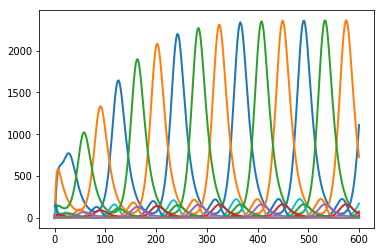

[[<matplotlib.lines.Line2D at 0x7fc031b8bb00>],

In [78]:
r.plot()

# Set node images
## Create images for species
In a first step we want to display images in the network.
For this the individual figures are created and store in the results folder

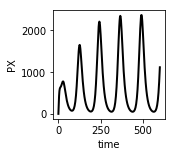

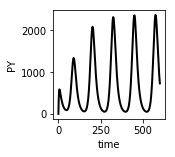

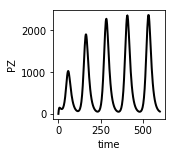

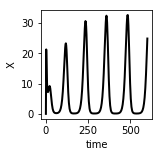

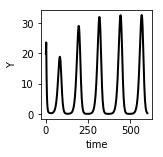

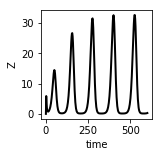

In [32]:
# create results folder
import os
results_dir = "./results/{}".format(biomodel)
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

# Create images for all species
time = df.index
for sbml_id in df.columns:
    # Create plot
    plt.figure(figsize=[2,2])
    plt.plot(time, df[sbml_id], linewidth=2, color="black")
    plt.xlabel('time')
    plt.ylabel(sbml_id)
    plt.savefig('{}/{}.png'.format(results_dir, sbml_id))

## Serve images
We run a simple file server to serve the images via URL.

In [34]:
# !!! serve the images on webserver
# cd cyrest-challenge
# python -m SimpleHTTPServer
# python3 -m http.server
# http://localhost:8000/results/BIOMD0000000012/

The images are than reachable under  
http://localhost:8000/results/BIOMD0000000012/

In [49]:
# DataFrame for node views
# df_vs_node = pd.DataFrame(index=node_suids, columns=['NODE_CUSTOM_PAINT_1'])
df_vs_node = pd.DataFrame(index=node_suids, columns=['NODE_IMAGE_CHART_1'])
# df_vs_node = pd.DataFrame(index=node_suids, columns=['NODE_FILL_COLOR'])

# apply all visual changes for the timepoint
for index, row in df_vs_node.iterrows():
    sbml_id = suid2sid.get(index)
    # row['NODE_FILL_COLOR'] = '#FF0000'
    print(sbml_id)
    # row['NODE_IMAGE_CHART_1'] = 'BIOMD0000000012/{}.png'.format(sbml_id)
    row['NODE_IMAGE_CHART_1'] = 'http://localhost:8000/results/BIOMD0000000012/{}.png'.format(sbml_id)

print(df_vs_node)
# Apply for timepoint
view1.batch_update_node_views(df_vs_node)
df_vs_node

PX
PY
PZ
X
Y
Z
                                    NODE_IMAGE_CHART_1
116  http://localhost:8000/results/BIOMD0000000012/...
118  http://localhost:8000/results/BIOMD0000000012/...
120  http://localhost:8000/results/BIOMD0000000012/...
122  http://localhost:8000/results/BIOMD0000000012/...
124  http://localhost:8000/results/BIOMD0000000012/...
126  http://localhost:8000/results/BIOMD0000000012/...


,NODE_IMAGE_CHART_1
116,http://localhost:8000/results/BIOMD0000000012/...
118,http://localhost:8000/results/BIOMD0000000012/...
120,http://localhost:8000/results/BIOMD0000000012/...
122,http://localhost:8000/results/BIOMD0000000012/...
124,http://localhost:8000/results/BIOMD0000000012/...
126,http://localhost:8000/results/BIOMD0000000012/...


In [19]:
# apply styles
# cy.style.apply(style=minimal_style, network=base_net)
# apply layout
# cy.layout.apply(name='force-directed', network=base_net)
